In [1]:
import os
os.environ['PYTHONHASHSEED']=str(0)
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.set_random_seed(0)

# ## uncomment for reproducibility ##
# from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)

import pandas as pd
import matplotlib.pyplot as plt
import pickle
import itertools
import time
import itertools
from IPython.display import display, clear_output

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.initializers import glorot_uniform

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.


In [2]:
VERSION = '06'

directory= f'../models/{VERSION}'
if not os.path.exists(directory):
    os.makedirs(directory)

In [3]:
def play_bell():
    import winsound
    duration = 200  # millisecond
    freq = 440  # Hz
    for i in range(5):
        winsound.Beep(int(freq*(i/2+1)), duration)
        
class LossHistory(Callback):
    def __init__(self, number_of_epochs):
        self.number_of_epochs = number_of_epochs
        self.current_epoch = 0
    def on_train_begin(self, logs={}):
        self.initial_time = time.time()
    def on_batch_end(self, batch, logs={}):
        if logs['batch']==0:
            NUMBER_OF_DIESIS = 20
            self.current_epoch += 1
            progress = self.current_epoch/self.number_of_epochs
            diesis = np.round(progress*NUMBER_OF_DIESIS).astype('int')
            eta = (time.time()-self.initial_time) * (self.number_of_epochs/self.current_epoch -1)
            remaining_time = time.strftime("%Mmin %Ssec", time.gmtime(eta))
            print('\r[{}{}] acc:{:.3f} eta:{}'.format('#'*diesis, '-'*(NUMBER_OF_DIESIS-diesis), logs['acc'], remaining_time), end='')

## Hyperparameters setting

In [4]:
def create_grid(params={}, index=0):   
    best_model_path = '../models/{}/best_model_{}.pkl'.format(VERSION, index)
    
    current_grid = {
        'index'                  : [np.int    , index],
        'version'                : ['str'     , VERSION],
        'best_model_path'        : ['str'     , best_model_path],
        'params'                 : ['O'       , params],
        
        # Load and preprocess
        'batch_size_data'        : [np.int    , 200],
        'x_std'                  : [np.float  , 3.398],
        'y_std'                  : [np.float  , 2.926],
        'sigma_cut'              : [np.float  , 0.1],
        
        # Metrics
        'best_model_metric'      : ['str'     , 'val_acc'],
        'training_metric'        : ['str'     , 'accuracy'],
        
        # Random seeds
        'seed_skf'               : [np.int    , 0],
        'seed_numpy'             : [np.int    , 0],
        'seed_tensorflow'        : [np.int    , 0],
        'seed_random'            : [np.int    , 0],
        'seed_sklearn'           : [np.int    , 0],
        'seed_model'             : [np.int    , 0],
        
        # Model properties
        'input_shape'            : ['O'       , None],
        'LSTM_size'              : [np.int    , 256],        
        
        # Training parameters
        'learning_rate'          : [np.float  , 0.0001],
        'batch_size'             : [np.int    , 32],
        'epochs'                 : [np.int    , 200],
        'test_size'              : [np.float  , 0.15],
        'skf_n_splits'           : [np.int    , 5],
        'skf_split'              : [np.int    , 0],
        
        # Outputs
        'best_model_accuracy'    : [np.float  , 0],
        'fit_out'                : ['O'       , None]}

    for key, value in params.items():
        current_grid[key][1] = value
    return current_grid

def add_grid_and_save(grid):
    if os.path.isfile('../model_data/grid_{}.pkl'.format(grid['version'][1])):
        grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))
    else:
        grid_df = pd.DataFrame()
        for key in sorted(grid.keys()):
            grid_df[key] = pd.Series(dtype=grid[key][0])

    grid_df = grid_df.append({key:grid[key][1] for key in grid.keys()}, ignore_index=True)
    grid_df.to_pickle('../model_data/grid_{}.pkl'.format(grid['version'][1]))
    

## Dataset loading and preprocessing

In [5]:
from sklearn.model_selection import train_test_split
def load_data(grid):
    right = pd.read_csv("../data/right.txt", header=None).values.tolist()
    left = pd.read_csv("../data/left.txt", header=None).values.tolist()
    
    BATCH_SIZE = grid['batch_size_data'][1]
    batch_right = [right[i:i + BATCH_SIZE] for i in range(0, len(right), BATCH_SIZE)]
    batch_left = [left[i:i + BATCH_SIZE] for i in range(0, len(left), BATCH_SIZE)]

    X_load = np.array(batch_right + batch_left)
    y_load = np.array([0]*len(batch_right) + [1]*len(batch_left))

    X_train, X_test, y_train, y_test = train_test_split(X_load, y_load, test_size=0.15, random_state=42, shuffle=True)
    return X_train, X_test, y_train, y_test

In [6]:
def pre_process_data(X, y, grid):
    # relative mouse movement
    X_diff = X[:,:-1,:].copy()
    X_diff[:,:,0] = np.diff(X[:,:,0])
    X_diff[:,:,1] = np.diff(X[:,:,1])
    
    # remove batches with no mouse activity
    sigma_x = np.std(X_diff[:,:,0], axis=1)
    sigma_y = np.std(X_diff[:,:,1], axis=1)
    mask = (sigma_x>grid['sigma_cut'][1])*(sigma_y>grid['sigma_cut'][1])

    X_filt = X_diff[mask]
    y_filt = y[mask]

    
    # normalize data
    x_std = grid['x_std'][1] # np.mean(np.std(X_filt[:,:,0], axis=1))
    y_std = grid['y_std'][1] # np.mean(np.std(X_filt[:,:,1], axis=1))

    X_filt[:,:,0] = X_filt[:,:,0] / x_std
    X_filt[:,:,1] = X_filt[:,:,1] / y_std
    
    return X_filt, y_filt

## Model definition

In [7]:
def create_model(grid):
    model = Sequential()
    model.add(LSTM(grid['LSTM_size'][1], input_shape=grid['input_shape'][1], kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    model.add(Dense(1, activation='sigmoid', kernel_initializer=glorot_uniform(seed=grid['seed_model'][1])))
    return model


In [8]:
def train_model(X, y, model, grid):
    skf = StratifiedKFold(n_splits=grid['skf_n_splits'][1], shuffle=True, random_state=grid['seed_skf'][1])
    train_index, test_index = list(skf.split(X, y))[grid['skf_split'][1]]
    X_train, X_dev = X[train_index], X[test_index]
    y_train, y_dev = y[train_index], y[test_index]
    
    
    adam = Adam(lr=grid['learning_rate'][1])
    progrress_bar = LossHistory(grid['epochs'][1])
    chk = ModelCheckpoint(grid['best_model_path'][1] , monitor=grid['best_model_metric'][1],
                          save_best_only=True, mode='max', verbose=0) 
    
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=[grid['training_metric'][1]])
    grid['fit_out'][1] = model.fit(X_train, y_train, epochs=grid['epochs'][1], batch_size=grid['batch_size'][1],
                        callbacks=[chk, progrress_bar], validation_data=(X_dev, y_dev), verbose=0)
    grid['fit_out'][1].model = None
    return grid

In [9]:
def run_training(X, y, grid, verbose=True):
    initial_time = time.time()
    np.random.seed(grid['seed_numpy'][1])
    tf.set_random_seed(grid['seed_tensorflow'][1])
    random.seed(grid['seed_random'][1])

    grid['input_shape'][1] = (X.shape[1], 2)
    model = create_model(grid)
    grid = train_model(X, y, model, grid)

    grid['best_model_accuracy'][1] = np.max(grid['fit_out'][1].history['val_acc'])

    
    add_grid_and_save(grid)
    total_time = time.strftime("%Mmin %Ssec", time.gmtime((time.time() - initial_time)))
    print('  --  Model {} trained in {}'.format(grid['index'][1], total_time))
    return grid



### Run training

In [10]:
grid = create_grid()

X_train, X_test, y_train, y_test = load_data(grid)
X_train, y_train = pre_process_data(X_train, y_train, grid)
X_test, y_test = pre_process_data(X_test, y_test, grid)

In [11]:
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

def remap(x, in_min, in_max, out_min, out_max):
    return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min

def scale_params(point, actual_to_norm=True):
    # {'LSTM_size': (0, 1), 'learning_rate': (0, 1)}
    params = point.copy()
    if actual_to_norm:
        params['LSTM_size'] = remap(float(params['LSTM_size']), 20, 250, 0, 1)
        temp = np.log10(params['learning_rate'])
        params['learning_rate'] = remap(temp, -5, -2, 0, 1)
    else:
        params['LSTM_size'] = int(remap(params['LSTM_size'], 0, 1, 20, 250))
        temp = remap(params['learning_rate'], 0, 1, -5, -2)
        params['learning_rate'] = 10**temp
    return params


def test_params(next_point_to_probe):
    next_point_scaled = scale_params(next_point_to_probe, actual_to_norm=False)
    print(f'Testing {next_point_scaled}')
    grid = create_grid(next_point_scaled, index+initial_index)
    grid = run_training(X_train, y_train, grid, verbose=True)
    return grid['best_model_accuracy'][1]

In [12]:
def plot_optimization(optimizer, utility):
    def scale_array(xy):
        rescaled = np.ones(xy.shape)
        for index, point in enumerate(xy):
            norm_point = {'LSTM_size': point[0], 'learning_rate': point[1]}
            point = scale_params(norm_point, actual_to_norm=False)
            rescaled[index,:] = [point['LSTM_size'], point['learning_rate']]
        return rescaled

    optimizer.suggest(utility)

    x_grid = np.linspace(0, 1, 100)
    y_grid = np.linspace(0, 1, 100)
    xx, yy = np.meshgrid(x_grid, y_grid)
    XY = np.append(xx, yy).reshape(-1, 2, order='F')
    mean, sigma = optimizer._gp.predict(XY , return_std=True)
    max_point = scale_params(optimizer.max['params'], actual_to_norm=False)
    scaled_lims = scale_array(np.array([[0,0], [1,1]]))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
    for ax in (ax1, ax2):
        rescaled = scale_array(optimizer.space.params)
        ax.scatter(rescaled[:, 0], rescaled[:, 1], zorder=3, c=optimizer.space.target, cmap='inferno', marker='D')
        ax.scatter(max_point['LSTM_size'], max_point['learning_rate'], color='white', s=300, zorder=8, alpha=0.5)
        ax.set_yscale('log')
        ax.set_xlim(scaled_lims[0, 0], scaled_lims[1, 0])
        ax.set_ylim(scaled_lims[0, 1], scaled_lims[1, 1])

    xy_grid = scale_array(np.array([x_grid, y_grid]).T)
    ax1.contourf(xy_grid[:,0], xy_grid[:,1], mean.reshape(xx.shape), 90, zorder=1)
    ax2.contourf(xy_grid[:,0], xy_grid[:,1], sigma.reshape(xx.shape), 90, zorder=1)
    ax1.set_title('Mean')
    ax2.set_title('Sigma')
    plt.show()

Testing {'LSTM_size': 234, 'learning_rate': 0.0019153339597582546}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
[####################] acc:0.844 eta:00min 00sec  --  Model 532 trained in 08min 23sec


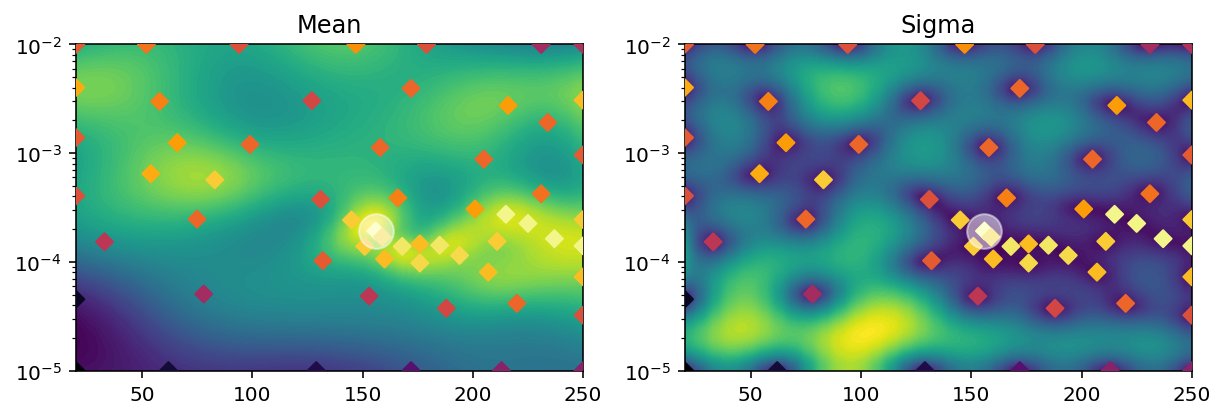

Testing {'LSTM_size': 190, 'learning_rate': 0.0019437979535215965}
[####################] acc:0.500 eta:00min 00sec  --  Model 533 trained in 07min 41sec


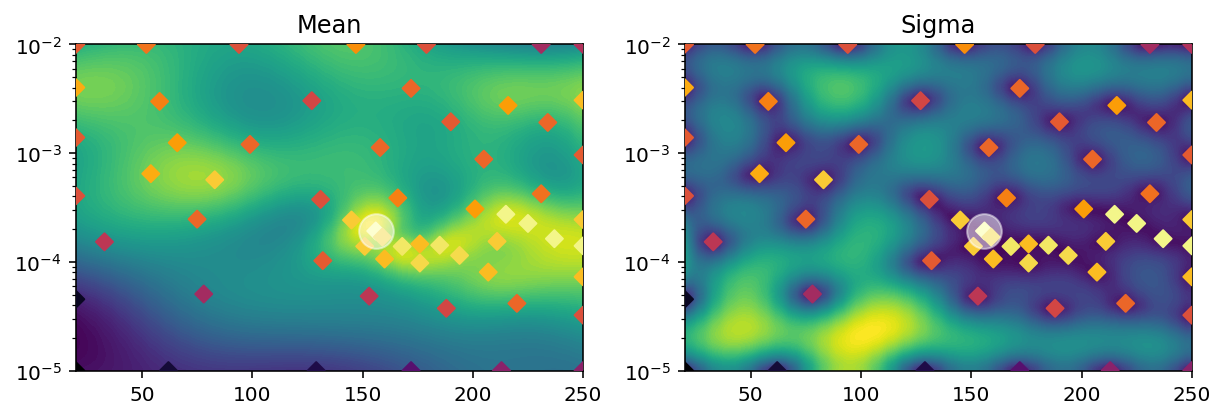

Testing {'LSTM_size': 154, 'learning_rate': 0.00023997422624852906}
[####################] acc:0.906 eta:00min 00sec  --  Model 534 trained in 07min 14sec


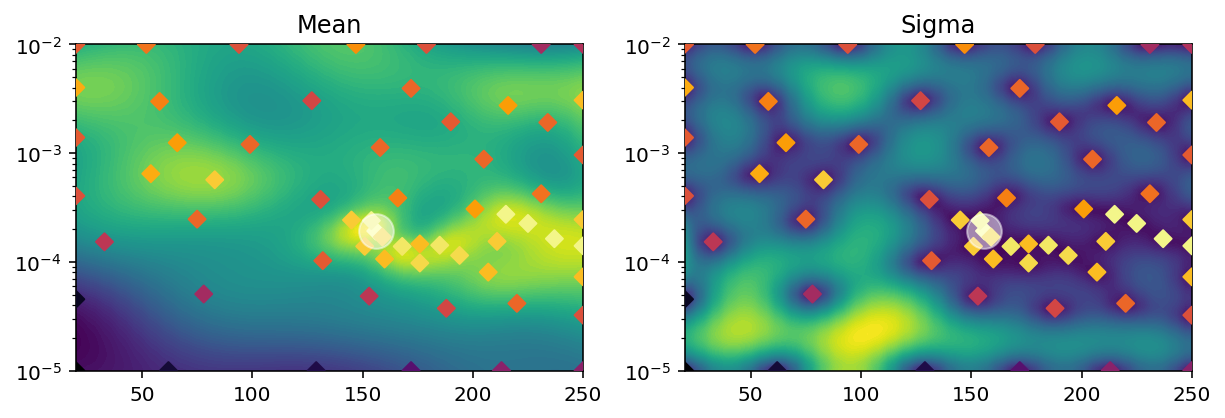

Testing {'LSTM_size': 37, 'learning_rate': 0.004988559427317276}
[####################] acc:0.969 eta:00min 00sec  --  Model 535 trained in 04min 31sec


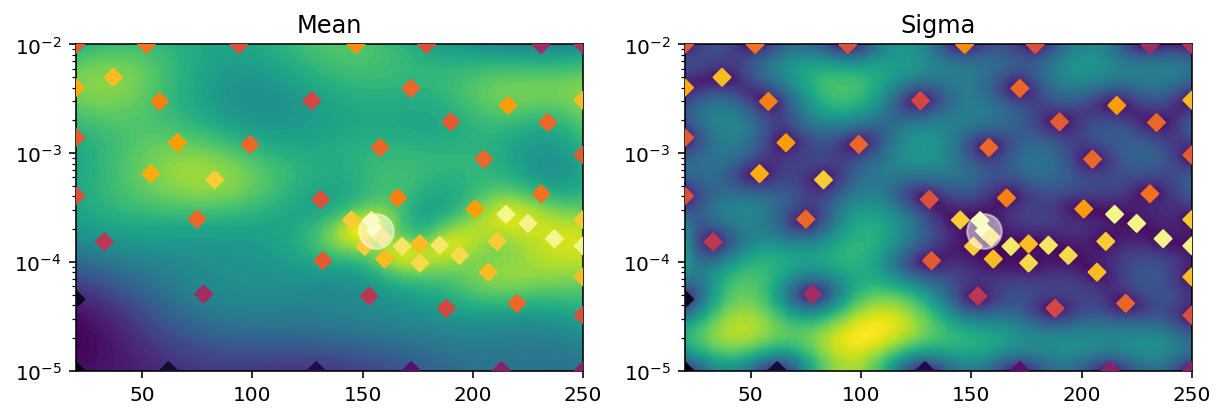

Testing {'LSTM_size': 233, 'learning_rate': 9.816333513044204e-05}
[####################] acc:0.812 eta:00min 00sec  --  Model 536 trained in 09min 04sec


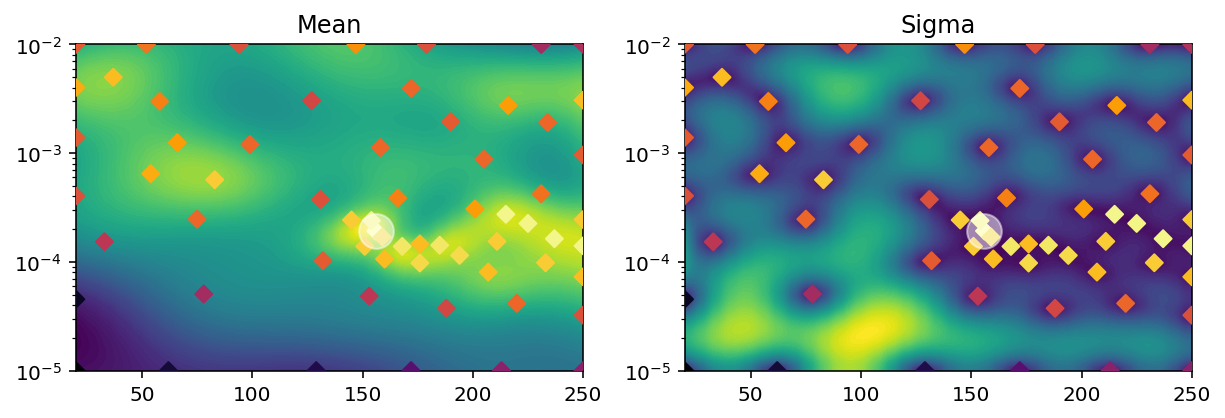

Testing {'LSTM_size': 151, 'learning_rate': 0.00019759518084803404}
[####################] acc:0.781 eta:00min 00sec  --  Model 537 trained in 07min 11sec


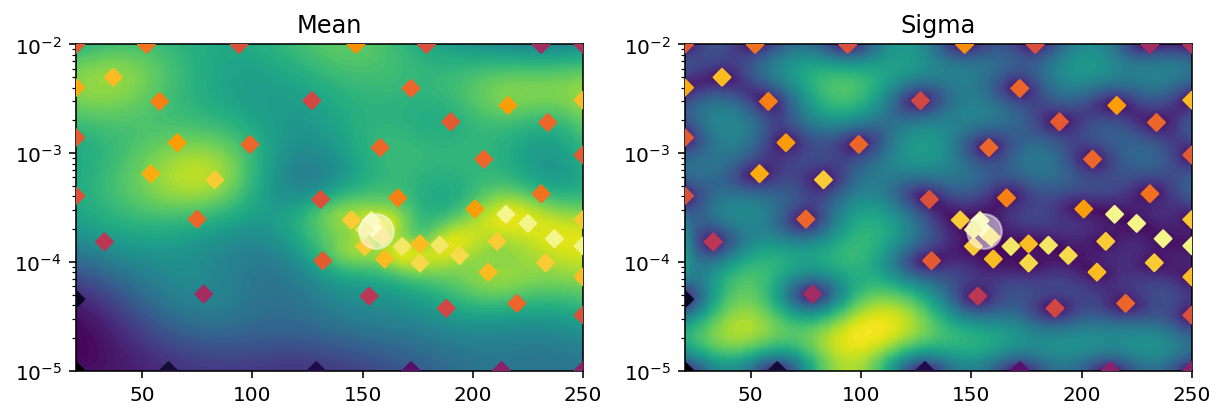

Testing {'LSTM_size': 88, 'learning_rate': 0.0038570786472872393}
[####################] acc:0.719 eta:00min 00sec  --  Model 538 trained in 06min 00sec


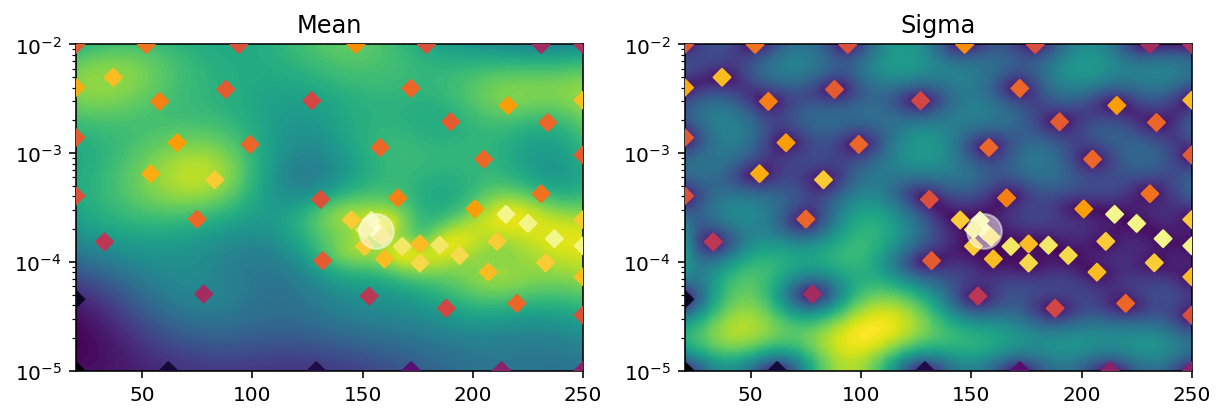

Testing {'LSTM_size': 123, 'learning_rate': 0.01}
[####################] acc:0.844 eta:00min 00sec  --  Model 539 trained in 06min 41sec


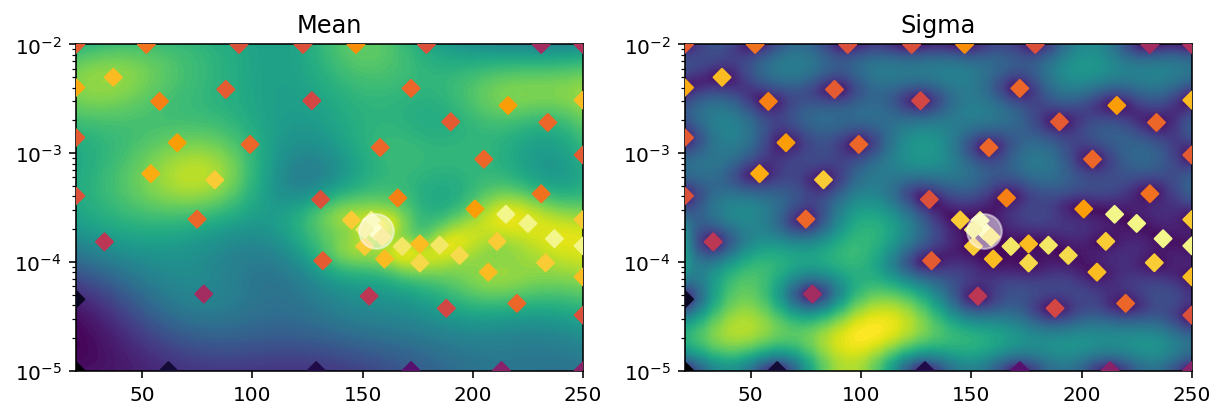

Testing {'LSTM_size': 233, 'learning_rate': 0.004483715470302864}
[####################] acc:0.781 eta:00min 00sec  --  Model 540 trained in 09min 03sec


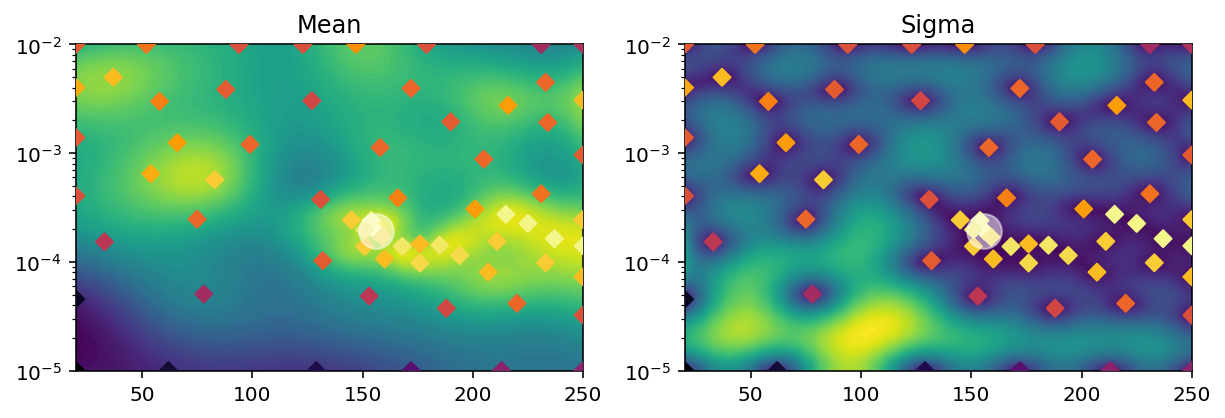

Testing {'LSTM_size': 67, 'learning_rate': 0.00047769843991715775}
[####################] acc:0.719 eta:00min 00sec  --  Model 541 trained in 05min 48sec


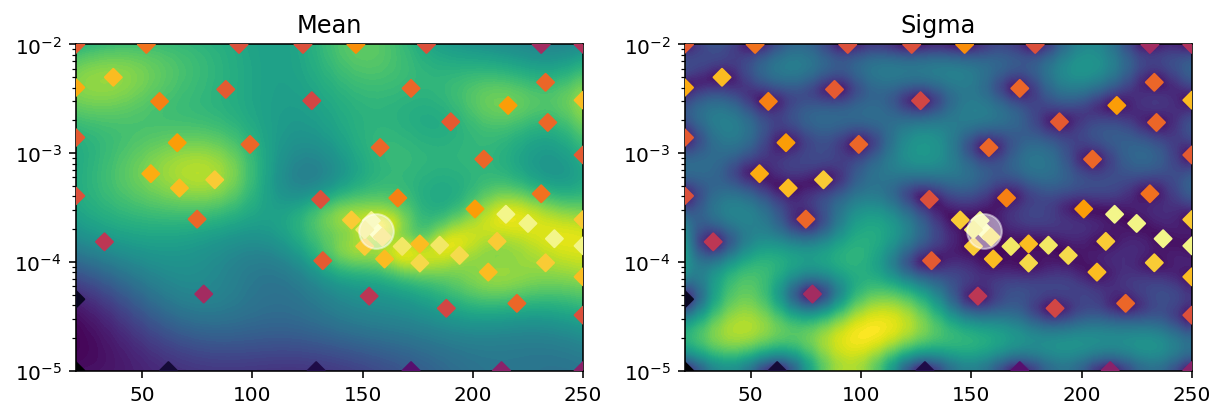

Testing {'LSTM_size': 35, 'learning_rate': 0.0025566362857689685}
[####################] acc:0.750 eta:00min 00sec  --  Model 542 trained in 04min 17sec


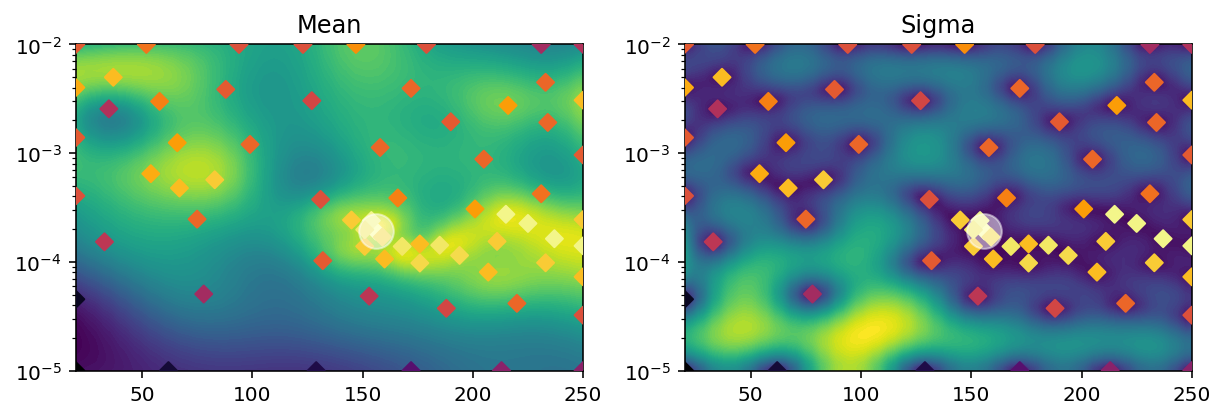

Testing {'LSTM_size': 63, 'learning_rate': 0.005829466200216237}
[####################] acc:0.750 eta:00min 00sec  --  Model 543 trained in 05min 45sec


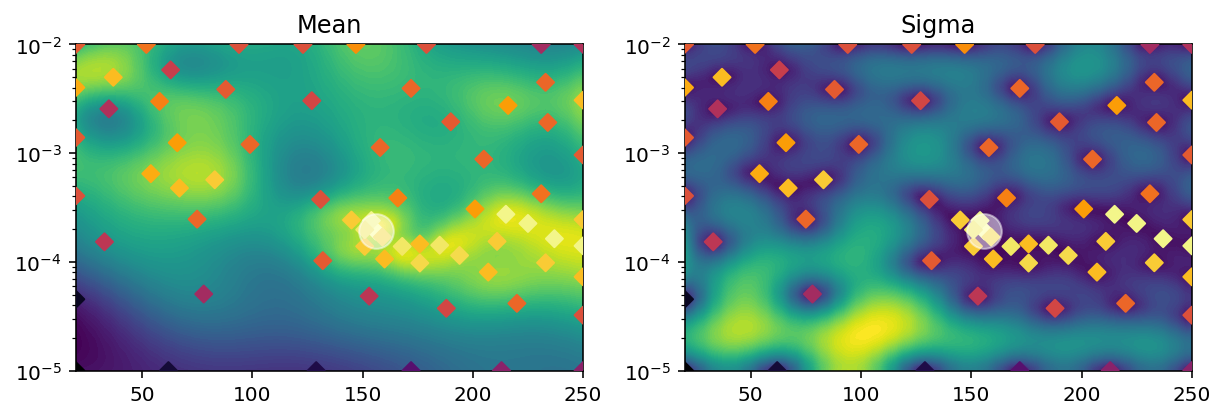

Testing {'LSTM_size': 201, 'learning_rate': 0.004826328651690057}
[####################] acc:0.781 eta:00min 00sec  --  Model 544 trained in 08min 20sec


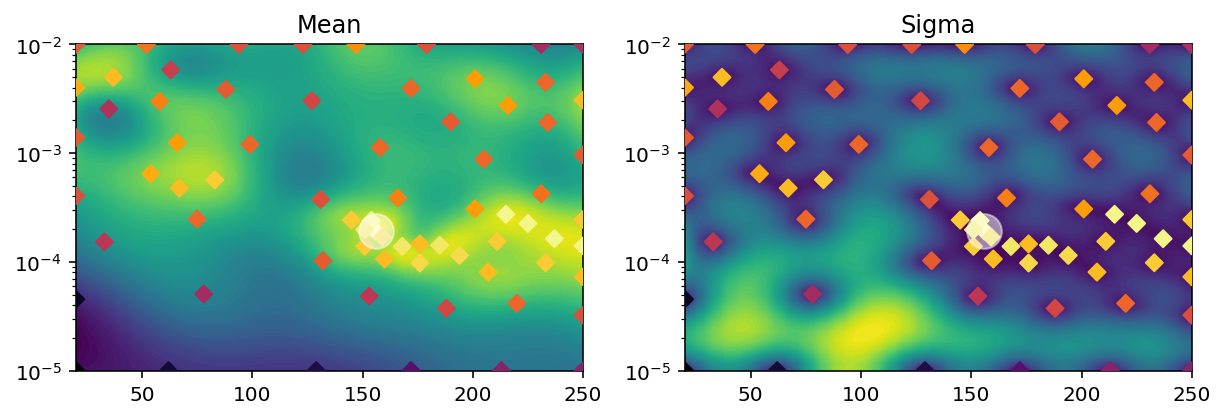

Testing {'LSTM_size': 75, 'learning_rate': 0.0007961702755232235}
[####################] acc:0.875 eta:00min 00sec  --  Model 545 trained in 05min 56sec


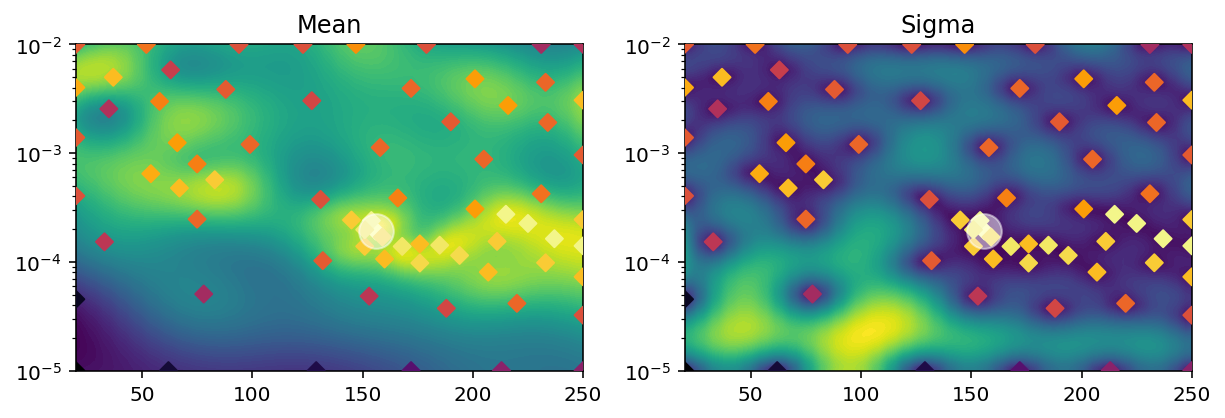

Testing {'LSTM_size': 95, 'learning_rate': 0.00035517374332983645}
[####################] acc:0.625 eta:00min 00sec  --  Model 546 trained in 06min 14sec


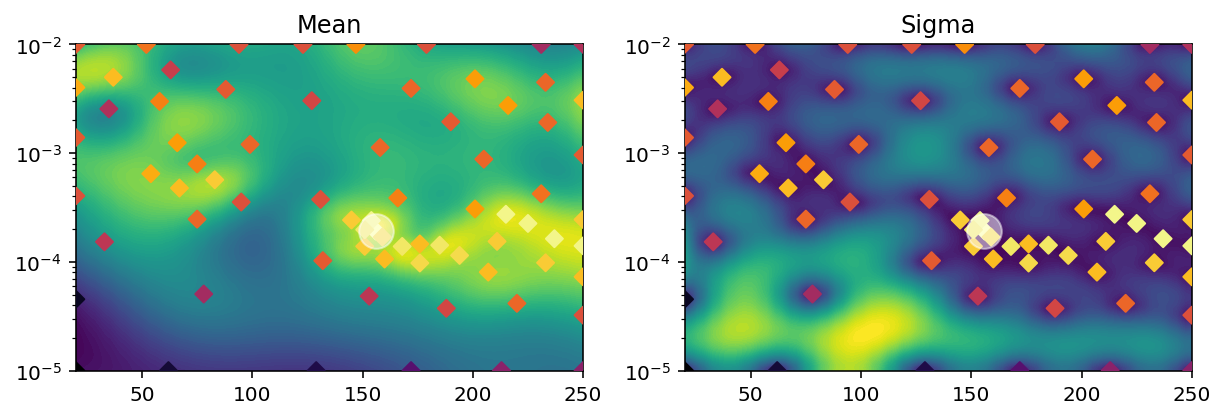

Testing {'LSTM_size': 47, 'learning_rate': 0.00033623927136381765}
[####################] acc:0.844 eta:00min 00sec  --  Model 547 trained in 05min 33sec


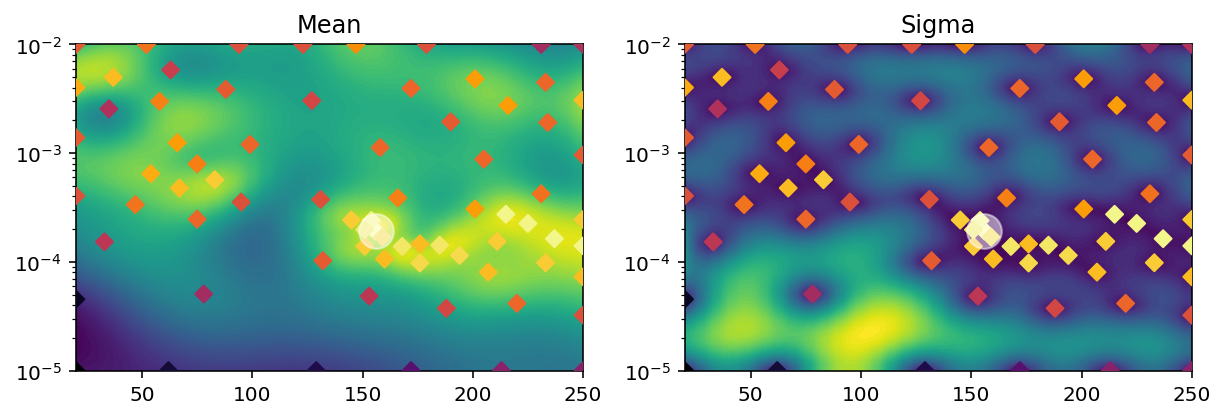

Testing {'LSTM_size': 107, 'learning_rate': 2.8240738723349494e-05}
[####################] acc:0.594 eta:00min 00sec  --  Model 548 trained in 06min 26sec


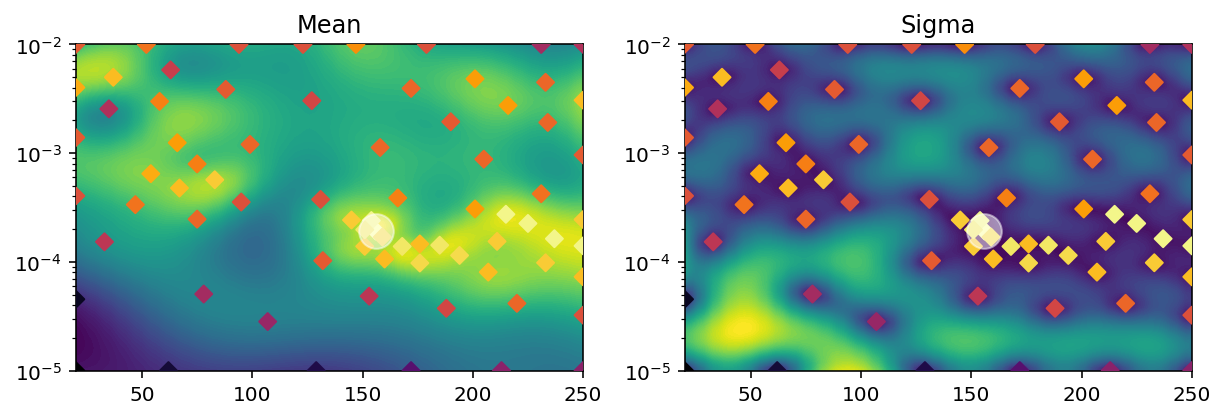

Testing {'LSTM_size': 158, 'learning_rate': 0.00021427339122367597}
[####################] acc:0.750 eta:00min 00sec  --  Model 549 trained in 07min 27sec


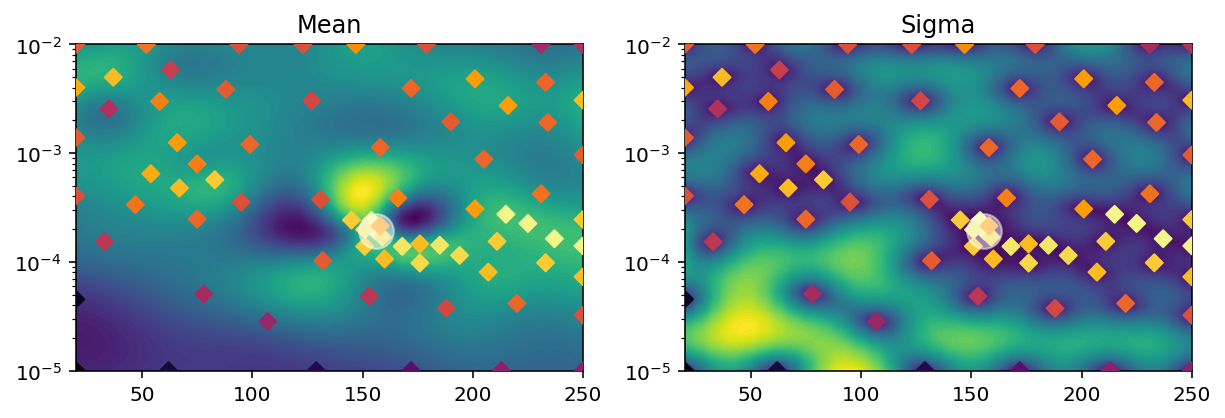

Testing {'LSTM_size': 149, 'learning_rate': 0.0005033800424241923}
[####################] acc:0.781 eta:00min 00sec  --  Model 550 trained in 07min 29sec


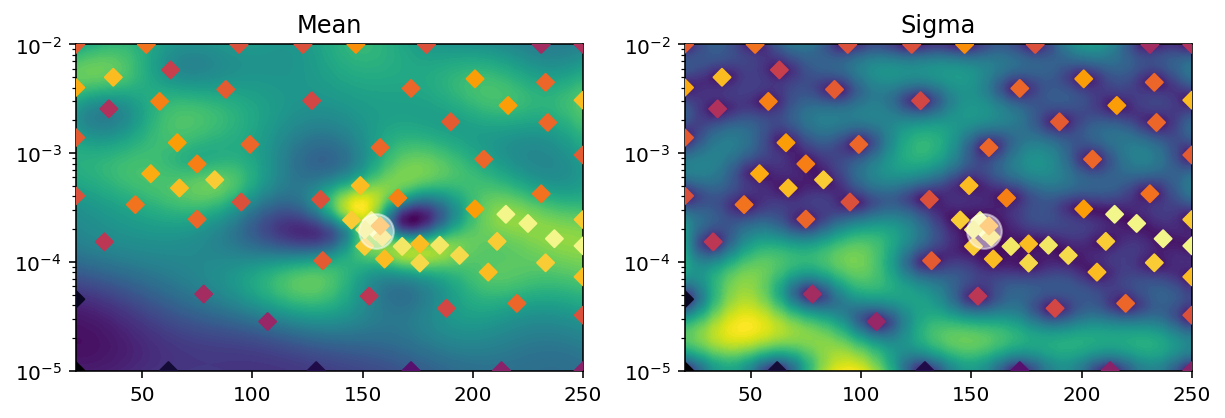

Testing {'LSTM_size': 109, 'learning_rate': 6.641426529263872e-05}
[####################] acc:0.781 eta:00min 00sec  --  Model 551 trained in 06min 37sec


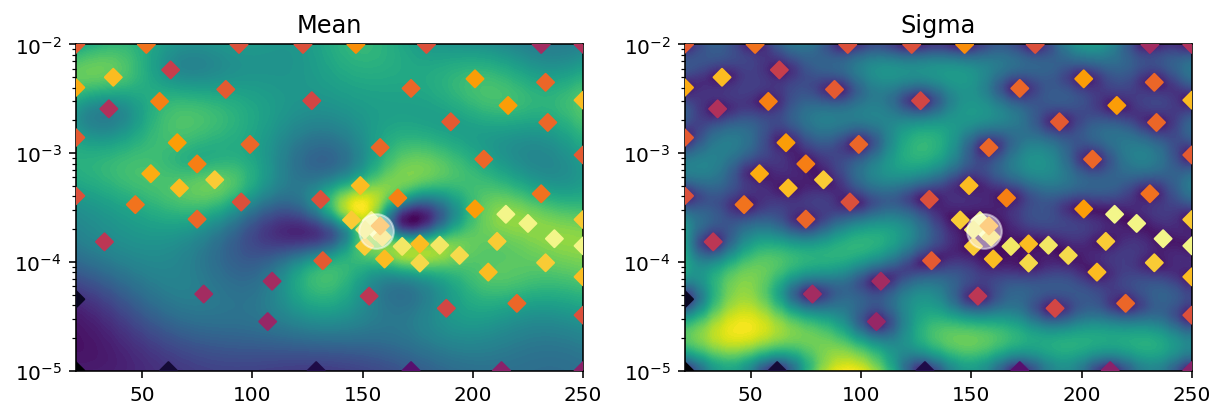

Wall time: 2h 17min 55s


In [13]:
%%time

optimizer = BayesianOptimization(
    f=test_params,
    pbounds={'LSTM_size': (0, 1), 'learning_rate': (0, 1)},
    verbose=0,
    random_state=30)

utility = UtilityFunction(kind="ucb", kappa=1., xi=None)


## BAYESIAN SEARCH
if not os.path.isfile('../model_data/grid_{}.pkl'.format(VERSION)):
    initial_index = 0
else:
    grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))
    initial_index = grid_df['index'].max() + 1
    
    for point, acc in zip(grid_df['params'], grid_df['best_model_accuracy']):
        point = scale_params(point, actual_to_norm=True)
        optimizer.register(params=point, target=acc)
        
for i in range(20):
    index = i + initial_index
    next_point_to_probe = optimizer.suggest(utility)
    target = test_params(next_point_to_probe)
    optimizer.register(params=next_point_to_probe, target=target)
    plot_optimization(optimizer, utility)

In [14]:
grid_df = pd.read_pickle('../model_data/grid_{}.pkl'.format(VERSION))

In [40]:
model_path = (grid_df
              .query('LSTM_size> 200') 
              .sort_values(['best_model_accuracy'], ascending = False)
              .iloc[0]['best_model_path'])
best_model = load_model(model_path)

In [41]:
test_preds = best_model.predict_classes(X_test)
acc_test = accuracy_score(y_test, test_preds)
print(f'Accuracy on the test set: {acc_test*100:.1f}%')

Accuracy on the test set: 65.3%


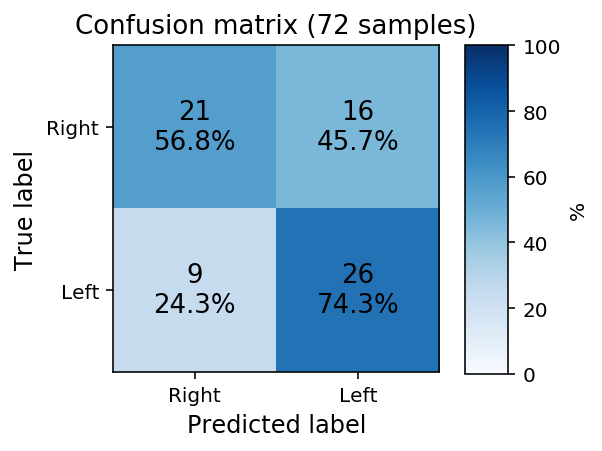

In [42]:
import itertools
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, test_preds)
# cm = confusion_matrix(y_dev, dev_preds)
#cm = confusion_matrix(y_train, training_preds)

classes=['Right', 'Left']
fig, ax = plt.subplots(1, figsize=(3,3))
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

cm_norm = cm / cm.sum(axis=1)*100
im = ax.imshow(cm_norm, cmap='Blues', interpolation='none', clim=(0,100))
ax.set_title(f'Confusion matrix ({y_test.shape[0]} samples)', size=13)


for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    ax.text(j, i, f'{cm[i,j]}\n{cm_norm[i, j]:.1f}%', size=13,
             horizontalalignment="center", verticalalignment="center",
             color="white" if cm[i, j] > 60 else "black")
ax.set_ylabel('True label', size=12)
ax.set_xlabel('Predicted label', size=12)

cb_ax = fig.add_axes([0.95, 0.12, 0.1, 0.76])
cb = fig.colorbar(im, cax=cb_ax, orientation='vertical')
cb.set_label('%')

fig.savefig(f'../plots/conf_matrix_{VERSION}.png', bbox_inches='tight')

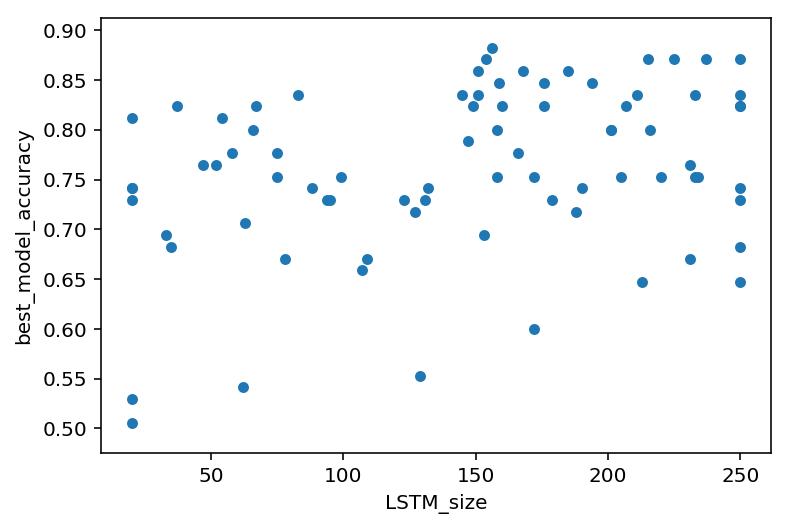

In [23]:
grid_df.plot('LSTM_size', 'best_model_accuracy', kind='scatter')

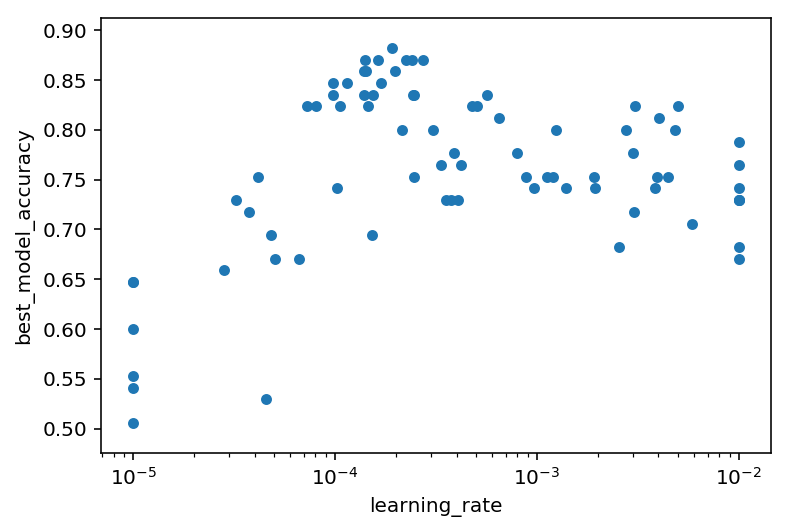

In [31]:
grid_df.plot('learning_rate', 'best_model_accuracy', kind='scatter', logx=True)

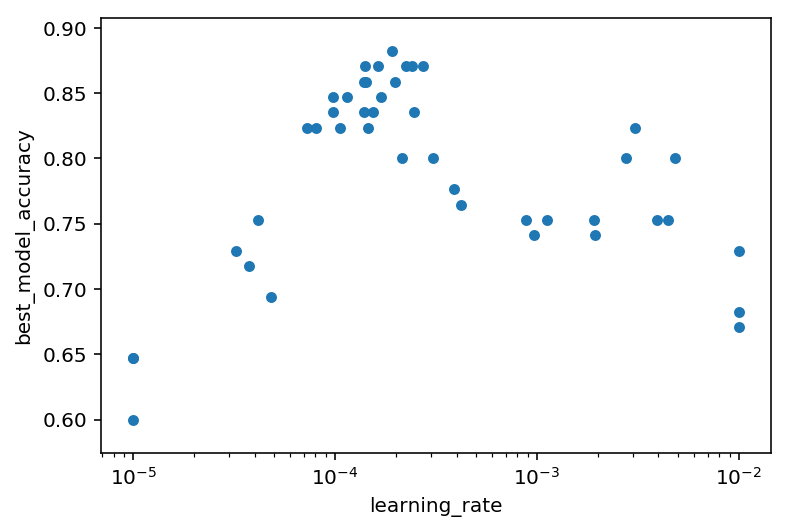

In [33]:
(grid_df
    .query('LSTM_size > 150')
    .plot('learning_rate', 'best_model_accuracy', kind='scatter', logx=True)
)

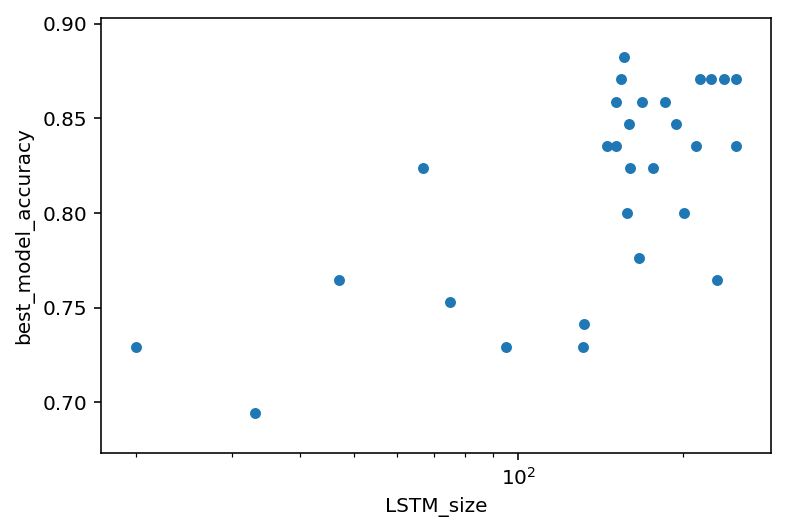

In [36]:
(grid_df
    .query('learning_rate > 1e-4 & learning_rate < 5e-4')
    .plot('LSTM_size', 'best_model_accuracy', kind='scatter', logx=True)
)

In [39]:
(grid_df
    .query('LSTM_size> 200') 
    .sort_values(['best_model_accuracy'], ascending = False)
)

LSTM_size  batch_size  batch_size_data  best_model_accuracy  \
22        215          32              200             0.870588   
43        237          32              200             0.870588   
51        225          32              200             0.870588   
48        250          32              200             0.870588   
28        211          32              200             0.835294   
63        233          32              200             0.835294   
10        250          32              200             0.835294   
37        250          32              200             0.823529   
17        250          32              200             0.823529   
12        207          32              200             0.823529   
35        201          32              200             0.800000   
40        216          32              200             0.800000   
71        201          32              200             0.800000   
36        231          32              200             0.764706   
67        233          32              200             0.752941   
45        220          32              200             0.752941   
59        234          32              200             0.752941   
29        205          32              200             0.752941   
14        250          32              200             0.741176   
34        250          32              200             0.729412   
2         250          32              200             0.682353   
9         231          32              200             0.670588   
4         213          32              200             0.647059   
23        250          32              200             0.647059   

   best_model_metric                  best_model_path  epochs  \
22           val_acc  ../models/06/best_model_105.pkl     200   
43           val_acc  ../models/06/best_model_250.pkl     200   
51           val_acc  ../models/06/best_model_258.pkl     200   
48           val_acc  ../models/06/best_model_255.pkl     200   
28           val_acc  ../models/06/best_model_111.pkl     200   
63           val_acc  ../models/06/best_model_536.pkl     200   
10           val_acc   ../models/06/best_model_20.pkl     200   
37           val_acc  ../models/06/best_model_120.pkl     200   
17           val_acc   ../models/06/best_model_48.pkl     200   
12           val_acc   ../models/06/best_model_43.pkl     200   
35           val_acc  ../models/06/best_model_118.pkl     200   
40           val_acc  ../models/06/best_model_123.pkl     200   
71           val_acc  ../models/06/best_model_544.pkl     200   
36           val_acc  ../models/06/best_model_119.pkl     200   
67           val_acc  ../models/06/best_model_540.pkl     200   
45           val_acc  ../models/06/best_model_252.pkl     200   
59           val_acc  ../models/06/best_model_532.pkl     200   
29           val_acc  ../models/06/best_model_112.pkl     200   
14           val_acc   ../models/06/best_model_45.pkl     200   
34           val_acc  ../models/06/best_model_117.pkl     200   
2            val_acc    ../models/06/best_model_2.pkl     200   
9            val_acc    ../models/06/best_model_9.pkl     200   
4            val_acc    ../models/06/best_model_4.pkl     200   
23           val_acc  ../models/06/best_model_106.pkl     200   

                                              fit_out  index input_shape  ...  \
22  <keras.callbacks.History object at 0x000001BFE...    105    (199, 2)  ...   
43  <keras.callbacks.History object at 0x000001BFE...    250    (199, 2)  ...   
51  <keras.callbacks.History object at 0x000001BFE...    258    (199, 2)  ...   
48  <keras.callbacks.History object at 0x000001BFE...    255    (199, 2)  ...   
28  <keras.callbacks.History object at 0x000001BFE...    111    (199, 2)  ...   
63  <keras.callbacks.History object at 0x000001BFE...    536    (199, 2)  ...   
10  <keras.callbacks.History object at 0x000001BFE...     20    (199, 2)  ...   
37  <keras.callbacks.History object at 0x000001BFE... 